FSM

In [ ]:
from keras.layers import Activation, Reshape, Lambda, dot, add, Input, BatchNormalization, ReLU, DepthwiseConv2D, Concatenate
from keras.layers import Conv1D, Conv2D, Conv3D
from keras.layers import MaxPool1D
from keras import backend as K
from keras.models import Model
from keras.regularizers import l2
from keras.losses import binary_crossentropy
from keras.models import Sequential
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Reshape, Concatenate, ReLU, DepthwiseConv2D, add
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Convolution3D, MaxPooling3D, ZeroPadding3D , ZeroPadding3D , UpSampling3D
from keras.layers.convolutional import Convolution2D, MaxPooling2D, UpSampling2D, ZeroPadding2D
from keras.optimizers import Adam , SGD
import numpy as np

loss

In [ ]:



def dice_coef(y_true, y_pred):
    TP = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred)
    return 2.0 * TP / union 
    

def dice_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)


def get_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


model

In [ ]:


from __future__ import print_function

import os
from skimage.transform import resize
from skimage.io import imsave
import numpy as np
from skimage.segmentation import mark_boundaries
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Conv2DTranspose
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from skimage.exposure import rescale_intensity
from keras.callbacks import History
from skimage import io
from keras.losses import binary_crossentropy
import os
import sys
import random

import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

In [ ]:

img_rows, img_cols = 192 , 224



In [ ]:
def bn_act(x, act=True):
    x = keras.layers.BatchNormalization()(x)
    if act == True:
        x = keras.layers.Activation("relu")(x)
    return x

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = bn_act(x)
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)
    return conv

def stem(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = keras.layers.Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([conv, shortcut])
    return output

def residual_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    shortcut = keras.layers.Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    shortcut = bn_act(shortcut, act=False)
    
    output = keras.layers.Add()([shortcut, res])
    return output

def upsample_concat_block(x, xskip):
    u = keras.layers.UpSampling2D((2, 2))(x)
    c = keras.layers.Concatenate()([u, xskip])
    return c



In [ ]:
def ResUNet():
    f = [16, 32, 64, 128, 256]
    inputs = keras.layers.Input((img_rows, img_cols, 3))
    
    ## Encoder
    e0 = inputs
    e1 = stem(e0, f[0])
    e2 = residual_block(e1, f[1], strides=2)
    e3 = residual_block(e2, f[2], strides=2)
    e4 = residual_block(e3, f[3], strides=2)
    e5 = residual_block(e4, f[4], strides=2)
    
    ## Bridge
    b0 = conv_block(e5, f[4], strides=1)
    b1 = conv_block(b0, f[4], strides=1)
    
    ## Decoder
    u1 = upsample_concat_block(b1, e4)
    d1 = residual_block(u1, f[4])
    
    u2 = upsample_concat_block(d1, e3)
    d2 = residual_block(u2, f[3])
    
    u3 = upsample_concat_block(d2, e2)
    d3 = residual_block(u3, f[2])
    
    u4 = upsample_concat_block(d3, e1)
    d4 = residual_block(u4, f[1])
    
    outputs = keras.layers.Conv2D(3, (1, 1), padding="same", activation="sigmoid")(d4)
    model = keras.models.Model(inputs, outputs)
    return model

compile

In [ ]:
  model = ResUNet()
  model.compile(optimizer=Adam(lr=1e-3), loss="binary_crossentropy", metrics=[dice_coef])
  model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 192, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 192, 224, 16) 448         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, 192, 224, 16) 64          conv2d_90[0][0]                  
__________________________________________________________________________________________________
activation_57 (Activation)      (None, 192, 224, 16) 0           batch_normalization_84[0][0]     
_______________________________________________________________________________________

train

In [ ]:
import os
import numpy as np
import nibabel 
import random
import matplotlib.pyplot as plt
import time
from keras.callbacks import ModelCheckpoint



In [ ]:

from google.colab import drive
drive.mount("/content/drive")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:

img_rows, img_cols = 224,192

In [ ]:
K.set_image_data_format('channels_last')  # TF dimension ordering in this code

In [ ]:
model_checkpoint = ModelCheckpoint('weights.h5', monitor='val_loss', save_best_only=True)

In [ ]:


from sklearn.model_selection import train_test_split


In [ ]:
batch_size=32
epoch_size=100

In [ ]:
#batch generator
#in akharin taghireeeeeeeeeeeeeeeeee
def generate_image_mask_from_data(batchsize):
  X_train=[]
  Y_train=[]
  batchcount = 0
  slide_index=np.arange(0,7916)
  random.shuffle(slide_index)


  for i in slide_index:
    image_2D=nibabel.load("/content/drive/MyDrive/classifir_mask_data/images_slides_train/image"+str(i)+".nii.gz").get_data()
    mask_2D=nibabel.load("/content/drive/MyDrive/classifir_mask_data/masks_slides_train/mask"+str(i)+".nii.gz").get_data()
    X_train_3D=[]
    for j in range(3):
      X_train_3D.append(image_2D.T)
    X_train_3D=np.array(X_train_3D).T
    X_train.append(X_train_3D)
    Y_train.append(mask_2D)
    batchcount+=1
    if batchcount > batchsize:
     
      yield(X_train,Y_train)
      X_train=[]
      Y_train=[]
      batchcount = 0
        
           


In [ ]:

loss=[]
dice=[]
loss_val=[]
dice_val=[]
c=0
num=[]


for epoch  in range(epoch_size):
  c=0
  print("start of epoch"+str(epoch+1)+"..........................................")
  for x,y in generate_image_mask_from_data(batch_size):
    print(c+1)
    
    x = np.array(x).reshape(-1,img_rows,img_cols,3)
    y = np.array(y).reshape(-1,img_rows,img_cols,3)
    X_train, X_test, Y_train, Y_test = train_test_split(x,y,test_size=0.25,random_state=0)
    
    start_time = time.time()
    history=model.train_on_batch(X_train,Y_train,reset_metrics=True, return_dict=True)
    history_test=model.test_on_batch(X_test, Y_test, reset_metrics=True, return_dict=True)
    
    c+=1
  
  dice.append(history['dice_coef'])
  loss.append(history["loss"])
  loss_val.append(history_test["loss"])
  dice_val.append(history_test['dice_coef'])
  model.save_weights('/content/drive/MyDrive/mode_classify/resnet/model/resnrt_classify_binary_not_all_dark_10085.h5')
  np.save('/content/drive/MyDrive/mode_classify/resnet/np/resnet_classify_binary_not_all_dark_10085-Dice-list',dice)
  np.save('/content/drive/MyDrive/mode_classify/resnet/np/resnet_classify_binary_not_all_dark_10085-Dice_val-list',dice_val)
  np.save('/content/drive/MyDrive/mode_classify/resnet/np/resnet_classify_binary_not_all_dark_10085-loss-list',loss)
  np.save('/content/drive/MyDrive/mode_classify/resnet/np/resnet_classify_binary_not_all_dark_10085-loss-val-list',loss_val)
  print('dice: ',history['dice_coef'])
  print('loss: ',history['loss'])
  print('dice_vall: ',history_test['dice_coef'])
  print('loss_vall: ',history_test['loss'])
  num.append(epoch)
  np.save('/content/drive/MyDrive/mode_classify/resnet/np/epoch_number',num)

print("finished")





start of epoch1..........................................


## ta in ja run kon derakht 

saving

In [ ]:
model.save_weights("/content/drive/My Drive/resnet/resweights1.h5")

In [ ]:
np_loss=np.save("/content/drive/My Drive/resnet/np30_loss1",np.array(loss))
np_dice=np.save("/content/drive/My Drive/resnet/np30_dice1",np.array(dice))
np_loss_val=np.save("/content/drive/My Drive/resnet/np30_loss_val1",np.array(loss_val))
np_dice_val=np.save("/content/drive/My Drive/resnet/np30_dice_val1",np.array(dice_val))

loading

In [ ]:
model = ResUNet()
model.compile(optimizer=Adam(lr=1e-3), loss="binary_crossentropy", metrics=[dice_coef])


In [ ]:
model.load_weights("/content/drive/MyDrive/mode_classify/resnet/model/resnrt_classify_binary_not_all_dark_10085.h5")

In [ ]:
loss=(np.load("/content/drive/My Drive/resnet/np30_loss.npy")).tolist()
dice=(np.load("/content/drive/My Drive/resnet/np30_dice.npy")).tolist()
loss_val=(np.load("/content/drive/My Drive/resnet/np30_loss_val.npy")).tolist()
dice_val=(np.load("/content/drive/My Drive/resnet/np30_dice_val.npy")).tolist()
c=0


start of epoch1..........................................


NameError: ignored

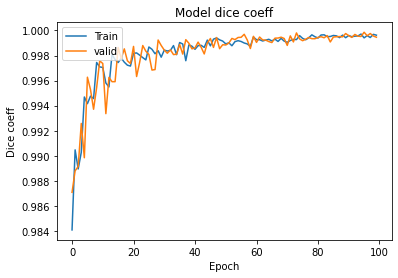

In [ ]:
plt.plot(dice)
plt.plot(dice_val)
plt.title('Model dice coeff')

plt.ylabel('Dice coeff')
plt.xlabel('Epoch')
plt.legend(['Train', 'valid'], loc='upper left')
plt.savefig("dice_train_on _batch_epoch100_ln_constant_ln.png")




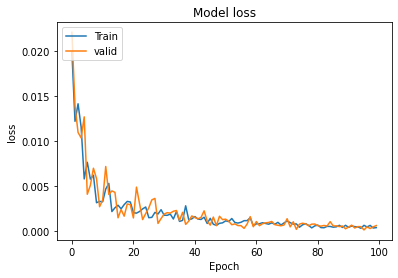

In [ ]:
plt.plot(loss)
plt.plot(loss_val)
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'valid'], loc='upper left')
plt.savefig("loss_train_on _batch_epoch100_ln_constant_ln.png")



**predict**

In [ ]:
#in 2 ta cell derakht

In [36]:
dic=[]
for i in range(0,2166):
  img_3chanell=[]
  img=nibabel.load("/content/drive/MyDrive/classifir_mask_data/images_slides_test/image"+str(i)+".nii.gz").get_data()
  mask=nibabel.load("/content/drive/MyDrive/classifir_mask_data/masks_slides_test/mask"+str(i)+".nii.gz").get_data()
  for j in range(3):
    img_3chanell.append(img.T)
  img=np.array(img_3chanell).T
  pred = model.predict(img.reshape(-1,192,224,3))
  TP = np.sum(pred[0] * mask)
  union = np.sum(pred[0]) + np.sum(mask)
  dic_pred=(2.0 * TP / union )
  dic.append(dic_pred)
  print(i)

  

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  """


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [37]:
np.mean(dic)

0.9901734699741266

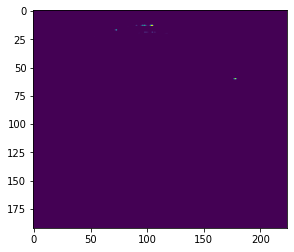

In [45]:
plt.imshow(pred[0][:,:,1])


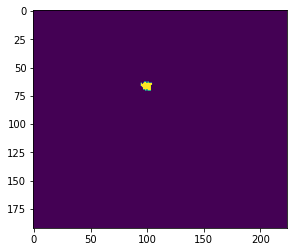

In [46]:

plt.imshow(mask[:,:,1])